In [1]:
# standard imports
import pandas as pd
import numpy as np
from datetime import datetime
import ast

In [2]:
# plotting
import matplotlib as plt
%matplotlib inline
import seaborn as sea

In [3]:
# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [4]:
# clustering libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
# Hyper Parameter tuning
from sklearn.model_selection import GridSearchCV

In [6]:
def knn_func(features, target, num_neighbors=5):
    x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.3, random_state=5175,
                                                    stratify=target)

    knn = KNeighborsClassifier(n_neighbors=num_neighbors)

    knn.fit(x_train, y_train)

    y_test_pred = knn.predict(x_test)

    print("The confusion matrix: \n")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nThe classification report:\n")
    print(classification_report(y_test, y_test_pred, digits=3))

In [7]:
#kick_train_data = pd.read_csv("data/kick_train.csv")
#kick_train_data.columns

In [8]:
colnamestokeep = ['blurb','goal','state','disable_communication','country','deadline']
colnamestokeep2 = ['state_changed_at','created_at','launched_at','static_usd_rate','category','profile']
fulllist = colnamestokeep + colnamestokeep2
print(fulllist)
kick_train_data = pd.read_csv("data/kick_train.csv", usecols=fulllist,names=['Unnamed: 0', 'id', 'photo', 'name', 'blurb', 'goal', 'state', 'slug',
       'disable_communication', 'country', 'currency', 'currency_symbol',
       'currency_trailing_code', 'deadline', 'state_changed_at', 'created_at',
       'launched_at', 'staff_pick', 'backers_count', 'static_usd_rate',
       'creator', 'location', 'category', 'profile', 'urls', 'source_url',
       'friends', 'is_starred', 'is_backing', 'permissions'],header=0,skipinitialspace=True)

['blurb', 'goal', 'state', 'disable_communication', 'country', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'static_usd_rate', 'category', 'profile']


In [9]:
kick_train_data.head()

,blurb,goal,state,disable_communication,country,deadline,state_changed_at,created_at,launched_at,static_usd_rate,category,profile
0,Angular is a minimalist card design for simpli...,17380.0,failed,False,US,1459283229,1459283230,1455845363,1456694829,1.000000,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f..."
1,Original songs and music videos to jump start ...,24000.0,failed,False,US,1484110800,1484110800,1475568868,1480946454,1.000000,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f..."
2,Our project is to launch a vegan lunch deliver...,40000.0,failed,False,CA,1408549628,1408549628,1405218883,1405957628,0.926746,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f..."
3,I have developed a process of my own which tra...,1000.0,successful,False,US,1364084914,1364084914,1360627778,1361496514,1.000000,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f..."
4,Need to pay an illustrator to bring my childre...,700.0,failed,False,GB,1382600001,1382600002,1379704502,1380008001,1.602384,"{""urls"":{""web"":{""discover"":""http://www.kicksta...","{""background_image_opacity"":0.8,""should_show_f..."


In [10]:
# remove target variable
kick_train_data_state = (kick_train_data['state'] == "successful").astype(int)
kick_train_data.drop(['state'],inplace=True,axis=1)

In [11]:
'''
Index(['Unnamed: 0', 'id', 'photo', 'name', 'blurb', 'goal', 'slug',
       'disable_communication', 'country', 'currency', 'currency_symbol',
       'currency_trailing_code', 'deadline', 'state_changed_at', 'created_at',
       'launched_at', 'static_usd_rate', 'creator', 'location', 'category',
       'profile', 'urls', 'source_url', 'friends', 'is_starred', 'is_backing',
       'permissions'],
'''
## drop unnamed:0         drop as it is just the row number
## drop id                drop as it is presumable just an identifier
## photo                  drop as it appears to be a link to the place where a picture exists. Caustious on this one as maybe there are
##                             things to learn from the photo
## name                   drop as it is just the name and I am not doing text parsing to get sentiment and create a deep neural net
## blurb                  KEEP - get length of blurb and use it as a feature
## goal                   KEEP - after multiplying by static_usd_rate as in local currency  
## state                  drop - will separate as %%%% TARGET VARIABLE %%%%
## slug                   drop
## disable_communication  KEEP - one hot encode 
## country                KEEP - one hot encode 
## currency?              drop - as tells us nothing more than goal once goal is converted to dollars
## currency_symbol?       drop - as tells us nothing more than goal once goal is converted to dollars
## currency_trailing_code drop - as it just tells us whether the currency symbol is a dollar or not
## deadline               KEEP = month of deadline and difference from launch
## state_changed_at       drop - one second after deadline so adds nothing
## created_at             KEEP - used to calculate
## launched_at            KEEP - month of launch and diff from created and diff from deadline
## static_usd_Rate        KEEP - just multiply it by goal to create a variable in standard units
## creator                drop
## location               drop
## category               KEEP -after split category and find the slug - interpret in two columns and one hot encode
## profile                drop
## urls                   drop as it seems to be a couple of urls only At this stage nothing to extract
## source_url             drop - on inspection if offers nothing over what category will offer us!
## friends                drop - all but 105 values are NaN and the 105 are a strange symbol (see below)
## is_starred             drop - one true, 104 false and the rest NAN. Cannot impute.
## is_backing             drop - one true, 104 false and the rest NAN. Cannot impute values
## permissions            drop - all but 105 values are NaN and the 105 are a strange symbol (see below)

"\nIndex(['Unnamed: 0', 'id', 'photo', 'name', 'blurb', 'goal', 'slug',\n       'disable_communication', 'country', 'currency', 'currency_symbol',\n       'currency_trailing_code', 'deadline', 'state_changed_at', 'created_at',\n       'launched_at', 'static_usd_rate', 'creator', 'location', 'category',\n       'profile', 'urls', 'source_url', 'friends', 'is_starred', 'is_backing',\n       'permissions'],\n"

In [12]:
# replace blurb by length of blurb
lengthofblurb = kick_train_data['blurb'].apply(lambda x: len(str(x)))
kick_train_data['lengthofblurb'] = lengthofblurb
kick_train_data.drop(['blurb'],inplace=True,axis=1)

In [13]:
# replace category, and what should be slug, by subcategory
subcategory = []
for entry in kick_train_data['category']:
    #print(entry)
    my_dict = ast.literal_eval(entry)
    slugvalue = my_dict['slug']
    subcategory.append(slugvalue.split('/')[1])
kick_train_data['subcategory'] = subcategory
kick_train_data.drop(['category'],inplace=True,axis=1)

In [14]:
import re
# replace category, and what should be slug, by subcategory
blurbinprofile = []
for entry in kick_train_data['profile']:
    #print(entry)
    entry = entry.replace('"','')
    #print(entry)
    m = re.search("blurb:(.*?),", entry)
    blurbinprofile.append(m.group(1))
    #my_dict = ast.literal_eval(entry)
    #slugvalue = my_dict['blurb']
    #blurbinprofile.append(slugvalue)
#blurbinprofile[0:20]
#kick_train_data['subcategory'] = subcategory
#kick_train_data.drop(['category'],inplace=True,axis=1)
#print(blurbinprofile[0:30])
blurbinprofile_one_zero = [0 if i == 'null' else 1 for i in blurbinprofile ]
#print(blurbinprofile[0:30])
kick_train_data['blurbinprofile'] = blurbinprofile_one_zero

In [15]:
# change goal to be in stable units
kick_train_data['goalinusdollars'] = kick_train_data['goal'] * kick_train_data['static_usd_rate']
#kick_train_data['goalinusdollars'] = goalinusdollars
kick_train_data.drop(['goal'],inplace=True,axis=1)

In [16]:
# deal with dates
kick_train_data['deadline'] = pd.to_datetime(kick_train_data['deadline'],origin='unix',unit='s')
kick_train_data['created_at'] = pd.to_datetime(kick_train_data['created_at'],origin='unix',unit='s')
kick_train_data['launched_at'] = pd.to_datetime(kick_train_data['launched_at'],origin='unix',unit='s')
kick_train_data['state_changed_at'] = pd.to_datetime(kick_train_data['state_changed_at'],origin='unix',unit='s')

In [17]:
# deal with dates part 2
openforfundingdiff = kick_train_data['deadline'] - kick_train_data['launched_at'] # diff between deadline and launch
openforfundingindays = openforfundingdiff.apply(lambda x: x.days) # give me my diffindayscolumn to add to dataframe

createdtolauncheddiff = kick_train_data['launched_at'] - kick_train_data['created_at'] # diff between deadline and launch
createdtolauncheddiffindays = createdtolauncheddiff.apply(lambda x: x.days) # give me my diffindayscolumn to add to dataframe

# month of deadline
#deadlinemonth = kick_train_data['deadline'].apply(lambda x: x.month)

# month of launch
#launchmonth = kick_train_data['launched_at'].apply(lambda x: x.month)

#
kick_train_data['openforfundingindays'] = openforfundingindays
kick_train_data['createdtolauncheddiffindays'] = createdtolauncheddiffindays
#kick_train_data['deadlinemonth'] = deadlinemonth
#kick_train_data['launchmonth'] = launchmonth

kick_train_data.drop(['deadline'],inplace=True,axis=1)
kick_train_data.drop(['created_at'],inplace=True,axis=1)
kick_train_data.drop(['launched_at'],inplace=True,axis=1)
kick_train_data.drop(['state_changed_at'],inplace=True,axis=1)

In [18]:
## drop columns I said I should because they are no good
#kick_train_data.drop(['Unnamed: 0'],inplace=True,axis=1)
#kick_train_data.drop(['id'],inplace=True,axis=1)
#kick_train_data.drop(['photo'],inplace=True,axis=1)
#kick_train_data.drop(['name'],inplace=True,axis=1)
#kick_train_data.drop(['slug'],inplace=True,axis=1)
#kick_train_data.drop(['currency'],inplace=True,axis=1)
#kick_train_data.drop(['currency_symbol'],inplace=True,axis=1)
#kick_train_data.drop(['currency_trailing_code'],inplace=True,axis=1)
#kick_train_data.drop(['creator'],inplace=True,axis=1)
#kick_train_data.drop(['location'],inplace=True,axis=1)
kick_train_data.drop(['profile'],inplace=True,axis=1)
#kick_train_data.drop(['urls'],inplace=True,axis=1)
#kick_train_data.drop(['source_url'],inplace=True,axis=1)
#kick_train_data.drop(['friends'],inplace=True,axis=1)
#kick_train_data.drop(['is_starred'],inplace=True,axis=1)
#kick_train_data.drop(['is_backing'],inplace=True,axis=1)
#kick_train_data.drop(['permissions'],inplace=True,axis=1)
kick_train_data.drop(['static_usd_rate'],inplace=True,axis=1)
kick_train_data.drop(['disable_communication'],inplace=True,axis=1)
#kick_train_data.drop(['deadlinemonth', 'launchmonth'],inplace=True,axis=1)

In [19]:
preencoding_kick_train_data = kick_train_data.copy(deep=True)

In [49]:
preencoding_kick_train_data.columns

Index(['country', 'lengthofblurb', 'subcategory', 'blurbinprofile',
       'goalinusdollars', 'openforfundingindays',
       'createdtolauncheddiffindays'],
      dtype='object')

In [50]:
new_var = preencoding_kick_train_data['goalinusdollars'] / preencoding_kick_train_data['openforfundingindays']

In [51]:
new_var.describe()

count    1.149330e+05
mean     1.231762e+03
std      4.432670e+04
min      1.234568e-02
25%      5.681818e+01
50%      1.612903e+02
75%      3.911108e+02
max      1.171924e+07
dtype: float64

In [20]:
kick_train_data = pd.get_dummies(data=kick_train_data, columns = ['country'], prefix=['country'])

In [21]:
kick_train_data = pd.get_dummies(data=kick_train_data, columns = ['subcategory'], prefix=['subcategory'])

In [22]:
kick_train_data.columns

Index(['lengthofblurb', 'blurbinprofile', 'goalinusdollars',
       'openforfundingindays', 'createdtolauncheddiffindays', 'country_AT',
       'country_AU', 'country_BE', 'country_CA', 'country_CH',
       ...
       'subcategory_video games', 'subcategory_weaving', 'subcategory_web',
       'subcategory_webcomics', 'subcategory_webseries',
       'subcategory_woodworking', 'subcategory_workshops',
       'subcategory_world music', 'subcategory_young adult',
       'subcategory_zines'],
      dtype='object', length=152)

In [23]:
rb = RobustScaler(quantile_range=(25, 75))

# Scaling numerical features

In [24]:
# super concerned about outliers so have introduced this
# numeric variables are lengthofblurb, goalinusdollars, 'openforfundingindays' and 'createdtolauncheddiffindays'
#rb_lengthofblurb = RobustScaler(quantile_range=(25, 75)).fit_transform(kick_train_data['lengthofblurb'].reshape(-1, 1))
#rb_goalinusdollars = RobustScaler(quantile_range=(25, 75)).fit_transform(kick_train_data['goalinusdollars'].reshape(-1, 1))
#rb_openforfundingindays = RobustScaler(quantile_range=(25, 75)).fit_transform(kick_train_data['openforfundingindays'].reshape(-1, 1))
#rb_createdtolauncheddiffindays = RobustScaler(quantile_range=(25, 75)).fit_transform(kick_train_data['createdtolauncheddiffindays'].reshape(-1, 1))

In [25]:
rb_lengthofblurb = rb.fit_transform(kick_train_data['lengthofblurb'].reshape(-1, 1))
rb_goalinusdollars = rb.fit_transform(kick_train_data['goalinusdollars'].reshape(-1, 1))
rb_openforfundingindays = rb.fit_transform(kick_train_data['openforfundingindays'].reshape(-1, 1))
rb_createdtolauncheddiffindays = rb.fit_transform(kick_train_data['createdtolauncheddiffindays'].reshape(-1, 1))

C:\Users\CaveC_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
C:\Users\CaveC_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
C:\Users\CaveC_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\CaveC_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [26]:
kick_train_data['rb_lengthofblurb'] = rb_lengthofblurb
kick_train_data['rb_goalinusdollars'] = rb_goalinusdollars
kick_train_data['rb_openforfundingindays'] = rb_openforfundingindays
kick_train_data['rb_createdtolauncheddiffindays'] = rb_createdtolauncheddiffindays

In [27]:
kick_train_data.drop(['lengthofblurb'],inplace=True,axis=1)
kick_train_data.drop(['goalinusdollars'],inplace=True,axis=1)
kick_train_data.drop(['openforfundingindays'],inplace=True,axis=1)
kick_train_data.drop(['createdtolauncheddiffindays'],inplace=True,axis=1)

In [53]:
kick_train_data['ratio'] = new_var

# K Nearest Neighbours classification

In [54]:
knn_func(kick_train_data, kick_train_data_state,num_neighbors=3)

The confusion matrix: 

[[12984  5729]
 [ 6200  9567]]

The classification report:

             precision    recall  f1-score   support

          0      0.677     0.694     0.685     18713
          1      0.625     0.607     0.616     15767

avg / total      0.653     0.654     0.654     34480



In [52]:
knn_func(new_var.reshape(-1, 1), kick_train_data_state,num_neighbors=3)

C:\Users\CaveC_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


The confusion matrix: 

[[11092  7621]
 [ 8442  7325]]

The classification report:

             precision    recall  f1-score   support

          0      0.568     0.593     0.580     18713
          1      0.490     0.465     0.477     15767

avg / total      0.532     0.534     0.533     34480



In [29]:
param = {'n_neighbors': list(range(3,10))}

x_train, x_test, y_train, y_test = train_test_split(kick_train_data, kick_train_data_state, 
                                                    test_size=0.3, random_state=5175,
                                                    stratify=kick_train_data_state)
knn = KNeighborsClassifier()

knn_gcv = GridSearchCV(knn, param, cv=5)

knn_gcv.fit(x_train, y_train)

y_test_pred = knn_gcv.predict(x_test)

print("The confusion matrix: \n")
print(confusion_matrix(y_test, y_test_pred))
print("\nThe classification report:\n")
print(classification_report(y_test, y_test_pred, digits=3))

KeyboardInterrupt: 

In [76]:
## 15 Jul Sunday evening. 
## 1. DONE - Tidy up so robust scaler + country + subcategpry still there. Everything else goes to end.
## 2. Need to add in a feature well correlated with "True" on the state - good predictor of success!
## 3. DONE - Add in a proper hyper parameter search rather than me guessing (3-10 for K)
## 4. If time:- look at different distance metric. Could use manhattan which seemed to be suggested on line.
## 5. lengthofblurb - is this offering anything try with and without

## try knn with a subset of variable

In [25]:
knn_func(kick_train_data, kick_train_data_state, 4)

The confusion matrix: 

[[15566  3147]
 [ 7565  8202]]

The classification report:

             precision    recall  f1-score   support

          0      0.673     0.832     0.744     18713
          1      0.723     0.520     0.605     15767

avg / total      0.696     0.689     0.680     34480



In [26]:
knn_func(kick_train_data, kick_train_data_state, 5)

The confusion matrix: 

[[13777  4936]
 [ 5784  9983]]

The classification report:

             precision    recall  f1-score   support

          0      0.704     0.736     0.720     18713
          1      0.669     0.633     0.651     15767

avg / total      0.688     0.689     0.688     34480



In [27]:
knn_func(kick_train_data, kick_train_data_state, 6)

The confusion matrix: 

[[15341  3372]
 [ 7170  8597]]

The classification report:

             precision    recall  f1-score   support

          0      0.681     0.820     0.744     18713
          1      0.718     0.545     0.620     15767

avg / total      0.698     0.694     0.687     34480



In [28]:
knn_func(kick_train_data, kick_train_data_state, 7)

The confusion matrix: 

[[13979  4734]
 [ 5777  9990]]

The classification report:

             precision    recall  f1-score   support

          0      0.708     0.747     0.727     18713
          1      0.678     0.634     0.655     15767

avg / total      0.694     0.695     0.694     34480



In [29]:
knn_func(kick_train_data, kick_train_data_state, 8)

The confusion matrix: 

[[15177  3536]
 [ 6904  8863]]

The classification report:

             precision    recall  f1-score   support

          0      0.687     0.811     0.744     18713
          1      0.715     0.562     0.629     15767

avg / total      0.700     0.697     0.692     34480



In [30]:
knn_func(kick_train_data, kick_train_data_state, 9)

The confusion matrix: 

[[14068  4645]
 [ 5804  9963]]

The classification report:

             precision    recall  f1-score   support

          0      0.708     0.752     0.729     18713
          1      0.682     0.632     0.656     15767

avg / total      0.696     0.697     0.696     34480



In [26]:
knn_func(kick_train_data, kick_train_data_state, 10)

The confusion matrix: 

[[15979  2734]
 [ 6365  9402]]

The classification report:

             precision    recall  f1-score   support

          0      0.715     0.854     0.778     18713
          1      0.775     0.596     0.674     15767

avg / total      0.742     0.736     0.731     34480



In [25]:
contvaronly = kick_train_data[['rb_goalinusdollars', 'rb_openforfundingindays',
       'rb_createdtolauncheddiffindays','rb_lengthofblurb']]

In [33]:
knn_func(contvaronly, kick_train_data_state)

The confusion matrix: 

[[12019  6694]
 [ 7188  8579]]

The classification report:

             precision    recall  f1-score   support

          0      0.626     0.642     0.634     18713
          1      0.562     0.544     0.553     15767

avg / total      0.596     0.597     0.597     34480



In [34]:
featureset2 = preencoding_kick_train_data[['goalinusdollars']]

In [35]:
knn_func(featureset2, kick_train_data_state)

The confusion matrix: 

[[11503  7210]
 [ 8524  7243]]

The classification report:

             precision    recall  f1-score   support

          0      0.574     0.615     0.594     18713
          1      0.501     0.459     0.479     15767

avg / total      0.541     0.544     0.541     34480



In [33]:
preencoding_kick_train_data['kick_train_data_state'] = kick_train_data_state

In [34]:
preencoding_kick_train_data.columns

Index(['disable_communication', 'country', 'lengthofblurb', 'supercategory',
       'subcategory', 'goalinusdollars', 'openforfundingindays',
       'createdtolauncheddiffindays', 'deadlinemonth', 'launchmonth',
       'kick_train_data_state'],
      dtype='object')

In [35]:
grouped = preencoding_kick_train_data.groupby('country')
a = grouped['kick_train_data_state'].agg(np.sum)
b = grouped['kick_train_data_state'].agg(np.size)
a/b

country
AT    0.236842
AU    0.345037
BE    0.327044
CA    0.379401
CH    0.261438
DE    0.248421
DK    0.388704
ES    0.222649
FR    0.383901
GB    0.440038
HK    0.273973
IE    0.317073
IT    0.165379
LU    0.533333
MX    0.221902
NL    0.267341
NO    0.354369
NZ    0.365854
SE    0.384314
SG    0.329412
US    0.476050
Name: kick_train_data_state, dtype: float64

In [33]:
grouped = preencoding_kick_train_data.groupby('disable_communication')
a = grouped['kick_train_data_state'].agg(np.sum)
b = grouped['kick_train_data_state'].agg(np.size)
a/b

disable_communication
False    0.459005
True     0.000000
Name: kick_train_data_state, dtype: float64

In [34]:
grouped = preencoding_kick_train_data.groupby('supercategory')
a = grouped['kick_train_data_state'].agg(np.sum)
b = grouped['kick_train_data_state'].agg(np.size)
a/b

supercategory
art             0.441517
comics          0.548794
crafts          0.218962
dance           0.533546
design          0.675542
fashion         0.261105
film & video    0.524560
food            0.211516
games           0.540126
journalism      0.171400
music           0.532871
photography     0.279384
publishing      0.447627
technology      0.000000
Name: kick_train_data_state, dtype: float64

In [35]:
grouped = preencoding_kick_train_data.groupby('deadlinemonth')
a = grouped['kick_train_data_state'].agg(np.sum)
b = grouped['kick_train_data_state'].agg(np.size)
a/b

deadlinemonth
1     0.439810
2     0.459780
3     0.486979
4     0.484048
5     0.482713
6     0.472377
7     0.426556
8     0.382000
9     0.428540
10    0.472385
11    0.489901
12    0.471230
Name: kick_train_data_state, dtype: float64

In [36]:
grouped = preencoding_kick_train_data.groupby('launchmonth')
a = grouped['kick_train_data_state'].agg(np.sum)
b = grouped['kick_train_data_state'].agg(np.size)
a/b

launchmonth
1     0.451645
2     0.480539
3     0.486995
4     0.486564
5     0.465264
6     0.431589
7     0.372034
8     0.437067
9     0.478236
10    0.487237
11    0.481745
12    0.440517
Name: kick_train_data_state, dtype: float64

In [37]:
grouped = preencoding_kick_train_data.groupby('subcategory')
a = grouped['kick_train_data_state'].agg(np.sum)
b = grouped['kick_train_data_state'].agg(np.size)
a/b

subcategory
3d printing          0.000000
academic             0.210438
accessories          0.300166
action               0.137787
animals              0.250000
animation            0.265938
anthologies          0.649789
apparel              0.260469
apps                 0.000000
architecture         0.217131
art books            0.507019
audio                0.246324
bacon                0.205128
blues                0.411429
calendars            0.391753
candles              0.106383
children's books     0.438078
childrenswear        0.180921
chiptune             0.750000
civic design         0.336735
classical music      0.642697
comedy               0.372563
comic books          0.565821
community gardens    0.238095
cookbooks            0.234463
country & folk       0.632720
couture              0.177515
crochet              0.178218
digital art          1.000000
diy                  0.157825
                       ...   
residencies          0.729167
restaurants          0.15977

In [38]:
preencoding_kick_train_data.columns

Index(['disable_communication', 'country', 'lengthofblurb', 'supercategory',
       'subcategory', 'goalinusdollars', 'openforfundingindays',
       'createdtolauncheddiffindays', 'deadlinemonth', 'launchmonth',
       'kick_train_data_state'],
      dtype='object')

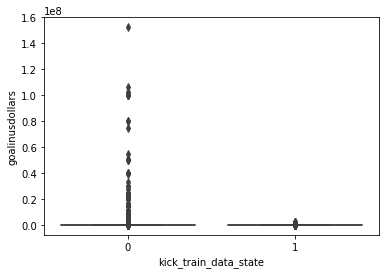

In [39]:
ax = sea.boxplot(x="kick_train_data_state", y='goalinusdollars', 
                  data=preencoding_kick_train_data)

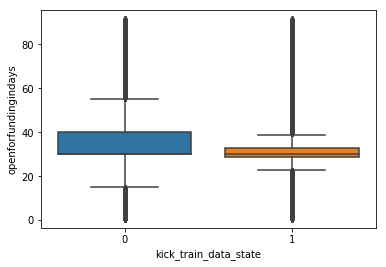

In [40]:
ax = sea.boxplot(x="kick_train_data_state", y='openforfundingindays', 
                  data=preencoding_kick_train_data)

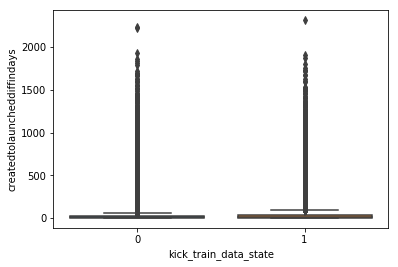

In [41]:
ax = sea.boxplot(x="kick_train_data_state", y='createdtolauncheddiffindays', 
                  data=preencoding_kick_train_data)

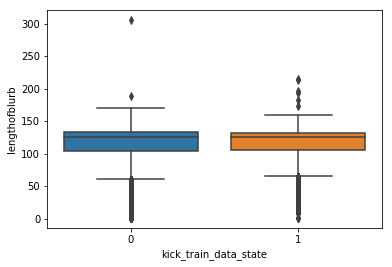

In [42]:
ax = sea.boxplot(x="kick_train_data_state", y='lengthofblurb', 
                  data=preencoding_kick_train_data)

In [43]:
features = preencoding_kick_train_data[['goalinusdollars', 'openforfundingindays', 'lengthofblurb','subcategory','country']]

In [44]:
features = pd.get_dummies(data=features, columns = ['subcategory', 'country'], prefix=['subcategory', 'country'])

In [45]:
knn_func(features, kick_train_data_state)

The confusion matrix: 

[[11775  6938]
 [ 7417  8350]]

The classification report:

             precision    recall  f1-score   support

          0      0.614     0.629     0.621     18713
          1      0.546     0.530     0.538     15767

avg / total      0.583     0.584     0.583     34480



In [55]:
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(kick_train_data, kick_train_data_state, 
                                                    test_size=0.3, random_state=5175,
                                                    stratify=kick_train_data_state)
dtc = DecisionTreeClassifier(max_depth=10)

dtc.fit(x_train, y_train)

y_test_pred2 = dtc.predict(x_test)

print("The confusion matrix: \n")
print(confusion_matrix(y_test, y_test_pred2))
print("\nThe classification report:\n")
print(classification_report(y_test, y_test_pred2, digits=3))

The confusion matrix: 

[[18056   657]
 [ 8268  7499]]

The classification report:

             precision    recall  f1-score   support

          0      0.686     0.965     0.802     18713
          1      0.919     0.476     0.627     15767

avg / total      0.793     0.741     0.722     34480



In [56]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(x_train, y_train)

y_pred_gnb = gnb.predict(x_test)

print(confusion_matrix(y_test, y_test_pred2))

print(classification_report(y_test, y_pred_gnb))


[[18056   657]
 [ 8268  7499]]
             precision    recall  f1-score   support

          0       0.91      0.04      0.08     18713
          1       0.47      0.99      0.64     15767

avg / total       0.71      0.48      0.34     34480



In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [66]:
kick_train_data.columns

Index(['blurbinprofile', 'country_AT', 'country_AU', 'country_BE',
       'country_CA', 'country_CH', 'country_DE', 'country_DK', 'country_ES',
       'country_FR',
       ...
       'subcategory_woodworking', 'subcategory_workshops',
       'subcategory_world music', 'subcategory_young adult',
       'subcategory_zines', 'rb_lengthofblurb', 'rb_goalinusdollars',
       'rb_openforfundingindays', 'rb_createdtolauncheddiffindays', 'ratio'],
      dtype='object', length=153)

In [67]:
# remove this just checking collinearity
kick_train_data.drop(['rb_openforfundingindays'],inplace=True,axis=1)
kick_train_data.drop(['rb_goalinusdollars'],inplace=True,axis=1)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(kick_train_data, kick_train_data_state, 
                                                    test_size=0.3, random_state=5175,
                                                    stratify=kick_train_data_state)


lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(x_train, y_train)

y_pred_lda = lda.predict(x_test)
print(classification_report(y_test, y_pred_lda, digits=3))

             precision    recall  f1-score   support

          0      0.719     0.914     0.805     18713
          1      0.849     0.577     0.687     15767

avg / total      0.779     0.760     0.751     34480



In [62]:
qda = QuadraticDiscriminantAnalysis(reg_param=0.1)
qda.fit(x_train, y_train)

y_pred_qda = qda.predict(x_test)
print(classification_report(y_test, y_pred_qda, digits=3))


C:\Users\CaveC_000\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


             precision    recall  f1-score   support

          0      0.917     0.055     0.103     18713
          1      0.470     0.994     0.638     15767

avg / total      0.712     0.484     0.348     34480



### Redundant Code

In [ ]:
# replace category, and what should be slug, by two useful varibles
supercategory = []
subcategory = []
for entry in kick_train_data['category']:
    my_dict = ast.literal_eval(entry)
    slugvalue = my_dict['slug']
    supercategory.append(slugvalue.split('/')[0])
    subcategory.append(slugvalue.split('/')[1])
kick_train_data['supercategory'] = supercategory
kick_train_data['subcategory'] = subcategory
kick_train_data.drop(['category'],inplace=True,axis=1)

In [ ]:
# upon investigation I am leaving these out but leaving in the code so I can reference it.
# kick_train_data = pd.get_dummies(data=kick_train_data, columns = ['deadlinemonth', 'launchmonth'], prefix=['deadlinemonth', 'launchmonth'])

In [ ]:
#kick_train_data = pd.get_dummies(data=kick_train_data, columns = ['disable_communication', 'country'], prefix=['disable_communication', 'country'])
# originally had both these in but removing "disable_communication"

In [ ]:
#kick_train_data = pd.get_dummies(data=kick_train_data, columns = ['supercategory', 'subcategory'], prefix=['supercategory', 'subcategory'])

In [ ]:
ss_lengthofblurb = StandardScaler().fit_transform(kick_train_data['lengthofblurb'].reshape(-1, 1))
ss_goalinusdollars = StandardScaler().fit_transform(kick_train_data['goalinusdollars'].reshape(-1, 1))
ss_openforfundingindays = StandardScaler().fit_transform(kick_train_data['openforfundingindays'].reshape(-1, 1))
ss_createdtolauncheddiffindays = StandardScaler().fit_transform(kick_train_data['createdtolauncheddiffindays'].reshape(-1, 1))
kick_train_data['ss_lengthofblurb'] = ss_lengthofblurb
kick_train_data['ss_goalinusdollars'] = ss_goalinusdollars
kick_train_data['ss_openforfundingindays'] = ss_openforfundingindays
kick_train_data['ss_createdtolauncheddiffindays'] = ss_createdtolauncheddiffindays

In [ ]:
kick_train_data.drop(['ss_lengthofblurb'],inplace=True,axis=1)
kick_train_data.drop(['ss_goalinusdollars'],inplace=True,axis=1)
kick_train_data.drop(['ss_openforfundingindays'],inplace=True,axis=1)
kick_train_data.drop(['ss_createdtolauncheddiffindays'],inplace=True,axis=1)

In [ ]:
kick_train_data.drop(['supercategory_art', 'supercategory_comics',
       'supercategory_crafts', 'supercategory_dance', 'supercategory_design',
       'supercategory_fashion', 'supercategory_film & video',
       'supercategory_food', 'supercategory_games', 'supercategory_journalism',
       'supercategory_music', 'supercategory_photography',
       'supercategory_publishing', 'supercategory_technology'],inplace=True,axis=1)

In [ ]:
kick_train_data.drop(['supercategory'],inplace=True,axis=1)